<a href="https://colab.research.google.com/github/Ryzinqx/Stroke-Classification-Using-PySpark/blob/main/FP_BDPAL_Kel_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Menginstall Library

In [ ]:
!pip install pyspark

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve, auc
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import Imputer
from imblearn.over_sampling import SMOTE
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from pyspark.ml.classification import LinearSVC, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Memasukkan Dataset

In [ ]:
spark = SparkSession.builder.appName('Stroke').getOrCreate()
df = spark.read.csv('/content/healthcare-dataset-stroke-data.csv', header = True, inferSchema = True)

In [ ]:
df.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [ ]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



Preprocessing

In [ ]:
# Memeriksa tipe data
print("Data Types:")
print(df.dtypes)

Data Types:
[('id', 'int'), ('gender', 'string'), ('age', 'double'), ('hypertension', 'int'), ('heart_disease', 'int'), ('ever_married', 'string'), ('work_type', 'string'), ('Residence_type', 'string'), ('avg_glucose_level', 'double'), ('bmi', 'string'), ('smoking_status', 'string'), ('stroke', 'int')]


In [ ]:
df = df.drop("id")

In [ ]:
# Mengganti nama kolom
for old_name, new_name in {
        'gender': 'jenis_kelamin',
        'age': 'usia',
        'hypertension': 'hipertensi',
        'heart_disease': 'penyakit_jantung',
        'ever_married': 'pernah_menikah',
        'work_type': 'jenis_pekerjaan',
        'Residence_type': 'jenis_tempat_tinggal',
        'avg_glucose_level': 'rata_rata_kadar_glukosa',
        'bmi': 'indeks_massa_tubuh',
        'smoking_status': 'status_merokok',
        'stroke': 'stroke'
      }.items():
      df = df.withColumnRenamed(old_name, new_name)

In [ ]:
# Mendefinisikan kolom apa saja yang kategorikal
categorical = ('jenis_kelamin', 'pernah_menikah', 'jenis_pekerjaan', 'jenis_tempat_tinggal', 'status_merokok')

In [ ]:
# Megubah data kategorikal
indexer_cols = [
    ('jenis_kelamin', 'jenis_kelamin_vec'),
    ('pernah_menikah', 'pernah_menikah_vec'),
    ('jenis_pekerjaan', 'jenis_pekerjaan_vec'),
    ('jenis_tempat_tinggal', 'jenis_tempat_tinggal_vec'),
    ('status_merokok', 'status_merokok_vec')
]

for input_col, output_col in indexer_cols:
    indexer = StringIndexer(inputCol=input_col, outputCol=output_col)
    df = indexer.fit(df).transform(df)

categorical = [col[0] for col in indexer_cols]
df = df.drop(*categorical)
df.show(5)

+----+----------+----------------+-----------------------+------------------+------+-----------------+------------------+-------------------+------------------------+------------------+
|usia|hipertensi|penyakit_jantung|rata_rata_kadar_glukosa|indeks_massa_tubuh|stroke|jenis_kelamin_vec|pernah_menikah_vec|jenis_pekerjaan_vec|jenis_tempat_tinggal_vec|status_merokok_vec|
+----+----------+----------------+-----------------------+------------------+------+-----------------+------------------+-------------------+------------------------+------------------+
|67.0|         0|               1|                 228.69|              36.6|     1|              1.0|               0.0|                0.0|                     0.0|               2.0|
|61.0|         0|               0|                 202.21|               N/A|     1|              0.0|               0.0|                1.0|                     1.0|               0.0|
|80.0|         0|               1|                 105.92|            

In [ ]:
# Menampilkan summary
df.summary().show()

+-------+------------------+------------------+-------------------+-----------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------------+------------------+
|summary|              usia|        hipertensi|   penyakit_jantung|rata_rata_kadar_glukosa|indeks_massa_tubuh|             stroke| jenis_kelamin_vec| pernah_menikah_vec|jenis_pekerjaan_vec|jenis_tempat_tinggal_vec|status_merokok_vec|
+-------+------------------+------------------+-------------------+-----------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------------+------------------+
|  count|              5110|              5110|               5110|                   5110|              5110|               5110|              5110|               5110|               5110|                    5110|              5110|
|   mean|43.226614481409015|0.0974559686888454|0.054011741682974

In [ ]:
# Mengubah tipe data kolom bmi
df = df.withColumn("indeks_massa_tubuh", df["indeks_massa_tubuh"].cast(DoubleType()))

In [ ]:
# Memerika missing value
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+----------+----------------+-----------------------+------------------+------+-----------------+------------------+-------------------+------------------------+------------------+
|usia|hipertensi|penyakit_jantung|rata_rata_kadar_glukosa|indeks_massa_tubuh|stroke|jenis_kelamin_vec|pernah_menikah_vec|jenis_pekerjaan_vec|jenis_tempat_tinggal_vec|status_merokok_vec|
+----+----------+----------------+-----------------------+------------------+------+-----------------+------------------+-------------------+------------------------+------------------+
|   0|         0|               0|                      0|                 0|     0|                0|                 0|                  0|                       0|                 0|
+----+----------+----------------+-----------------------+------------------+------+-----------------+------------------+-------------------+------------------------+------------------+



In [ ]:
# Mengisi nilai kosong pada kolom bmi dengan nilai mean
imputer = Imputer(
    inputCols=["indeks_massa_tubuh"],
    outputCols=["indeks_massa_tubuh_imputed"]
).setStrategy("mean")

df = imputer.fit(df).transform(df)

df = df.drop("indeks_massa_tubuh").withColumnRenamed("indeks_massa_tubuh_imputed", "indeks_massa_tubuh")

df.show(5)

+----+----------+----------------+-----------------------+------+-----------------+------------------+-------------------+------------------------+------------------+------------------+
|usia|hipertensi|penyakit_jantung|rata_rata_kadar_glukosa|stroke|jenis_kelamin_vec|pernah_menikah_vec|jenis_pekerjaan_vec|jenis_tempat_tinggal_vec|status_merokok_vec|indeks_massa_tubuh|
+----+----------+----------------+-----------------------+------+-----------------+------------------+-------------------+------------------------+------------------+------------------+
|67.0|         0|               1|                 228.69|     1|              1.0|               0.0|                0.0|                     0.0|               2.0|              36.6|
|61.0|         0|               0|                 202.21|     1|              0.0|               0.0|                1.0|                     1.0|               0.0|28.893236911794673|
|80.0|         0|               1|                 105.92|     1|     

In [ ]:
# Memerika missing value
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+----------+----------------+-----------------------+------+-----------------+------------------+-------------------+------------------------+------------------+------------------+
|usia|hipertensi|penyakit_jantung|rata_rata_kadar_glukosa|stroke|jenis_kelamin_vec|pernah_menikah_vec|jenis_pekerjaan_vec|jenis_tempat_tinggal_vec|status_merokok_vec|indeks_massa_tubuh|
+----+----------+----------------+-----------------------+------+-----------------+------------------+-------------------+------------------------+------------------+------------------+
|   0|         0|               0|                      0|     0|                0|                 0|                  0|                       0|                 0|                 0|
+----+----------+----------------+-----------------------+------+-----------------+------------------+-------------------+------------------------+------------------+------------------+



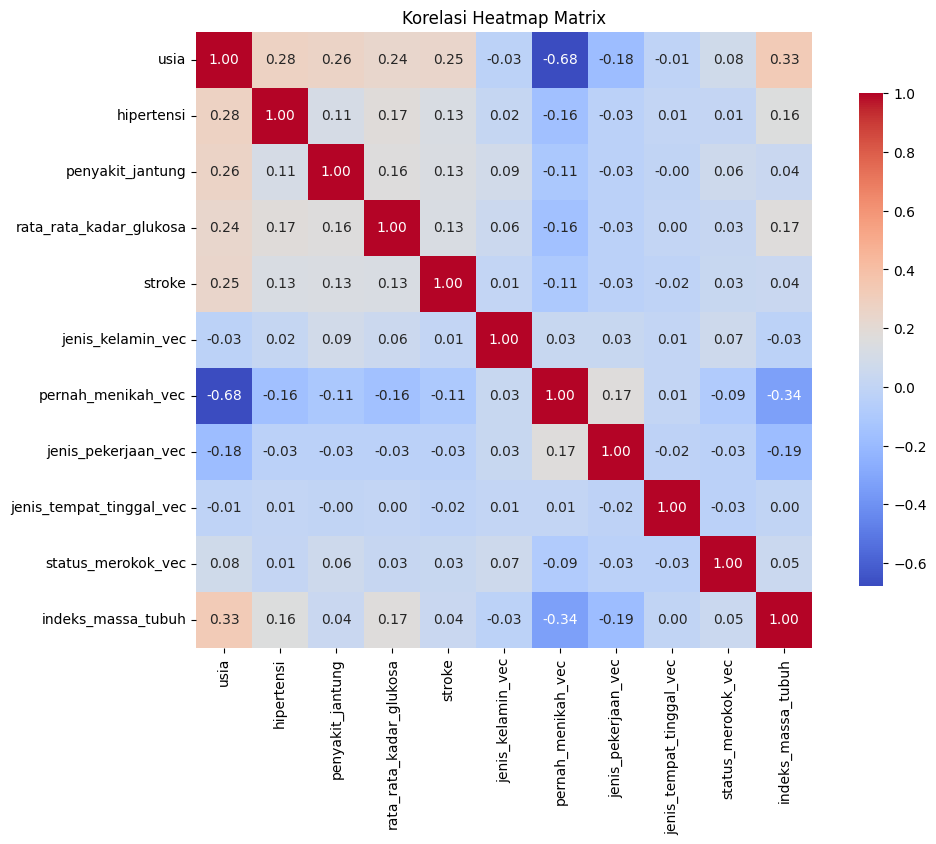

In [ ]:
# Korelasi matrix menggunakan metode pearson
pandas_df = df.toPandas()

correlation_matrix = pandas_df.corr(method='pearson')

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Korelasi Heatmap Matrix')
plt.show()

EDA

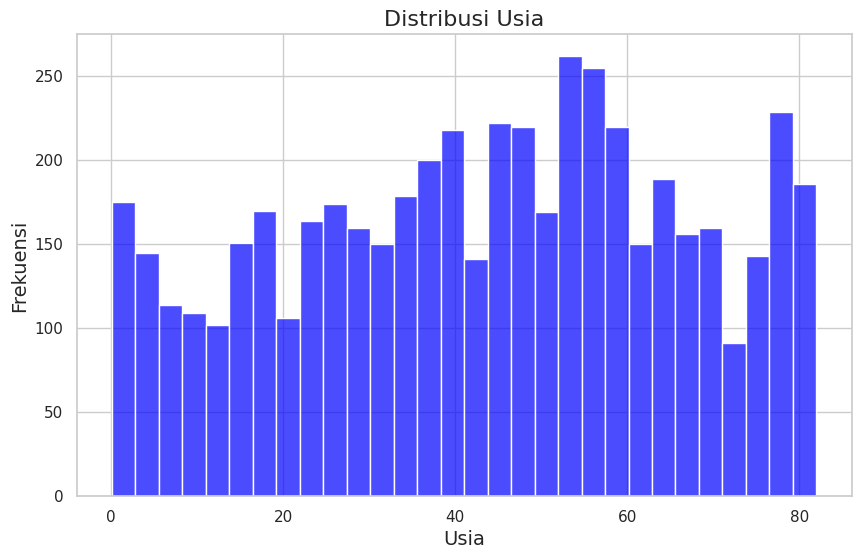

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

pandas_df = df.toPandas()
sns.histplot(pandas_df['usia'], bins=30, color='blue', alpha=0.7)
plt.title('Distribusi Usia', fontsize=16)
plt.xlabel('Usia', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.show()

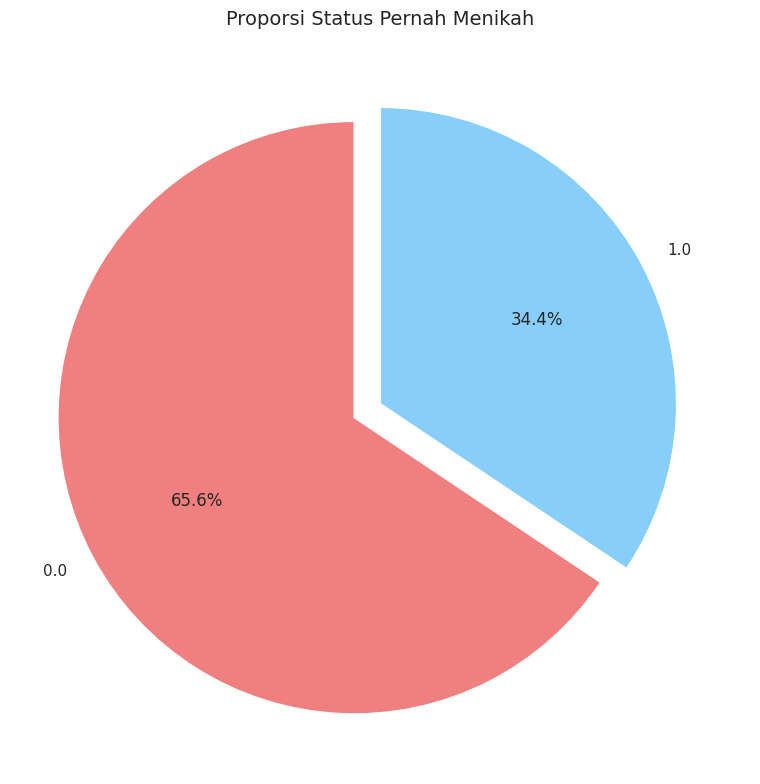

In [ ]:
married_counts = df.groupBy('pernah_menikah_vec').count().toPandas()

plt.figure(figsize=(8, 8))

plt.pie(married_counts['count'], labels=married_counts['pernah_menikah_vec'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'], explode=(0.1, 0))
plt.title('Proporsi Status Pernah Menikah', fontsize=14)
plt.ylabel('')

plt.tight_layout()
plt.show()

<ipython-input-21-e6589810327a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stroke', y='usia', data=pandas_df, palette='pastel')


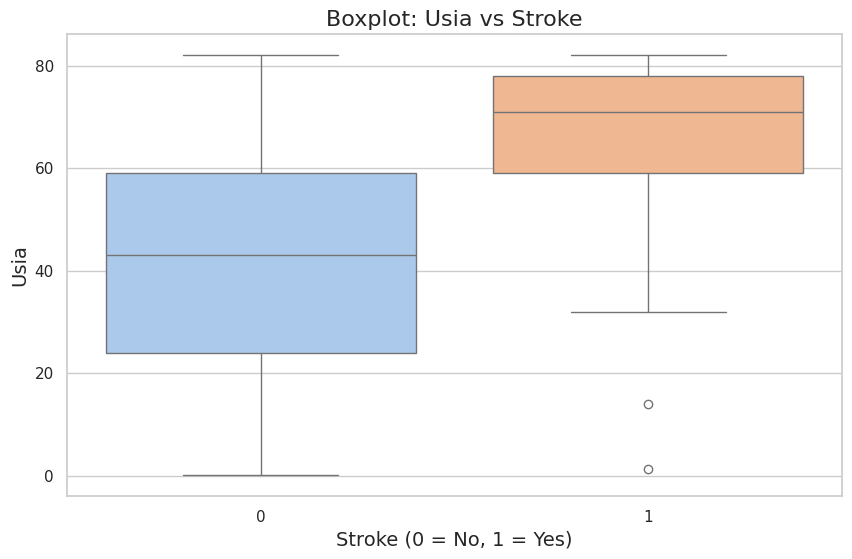

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='stroke', y='usia', data=pandas_df, palette='pastel')
plt.title('Boxplot: Usia vs Stroke', fontsize=16)
plt.xlabel('Stroke (0 = No, 1 = Yes)', fontsize=14)
plt.ylabel('Usia', fontsize=14)
plt.show()

<Figure size 800x500 with 0 Axes>

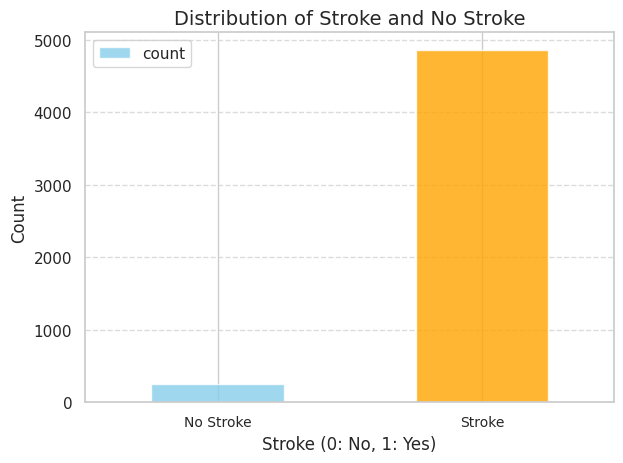

In [ ]:
import matplotlib.pyplot as plt

stroke_counts = df.groupBy('stroke').count().toPandas()

plt.figure(figsize=(8, 5))
stroke_counts.plot(kind='bar', x='stroke', y='count', color=['skyblue', 'orange'], alpha=0.8)
plt.title('Distribution of Stroke and No Stroke', fontsize=14)
plt.xlabel('Stroke (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Stroke', 'Stroke'], rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

stroke_counts = balanced_df.groupBy('stroke').count().toPandas()

plt.figure(figsize=(8, 5))
stroke_counts.plot(kind='bar', x='stroke', y='count', color=['skyblue', 'orange'], alpha=0.8)
plt.title('Distribution of Stroke and No Stroke', fontsize=14)
plt.xlabel('Stroke (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Stroke', 'Stroke'], rotation=0, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

NameError: name 'balanced_df' is not defined

Data Balance

In [ ]:
# Melakukan data balancing dengan menggunakan SMOTE
pandas_df = df.toPandas()

X = pandas_df.drop("stroke", axis=1)
y = pandas_df["stroke"]

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['stroke'] = y_resampled

spark = SparkSession.builder.appName('Stroke').getOrCreate()
balanced_df = spark.createDataFrame(resampled_df)

In [ ]:
# Membuat fitur vektor
feature_columns = [col for col in balanced_df.columns if col != 'stroke']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

balanced_df = assembler.transform(balanced_df)

Split Data

In [ ]:
# Melakukan Split Data
train, test = balanced_df.randomSplit([0.8, 0.2], seed=42)

Pemodelan

Random Forest

In [ ]:
rf = RandomForestClassifier(labelCol="stroke", featuresCol="features", numTrees=100, maxDepth=10)

rf_model = rf.fit(train)

rf_predictions = rf_model.transform(test)


Gradient Boost

In [ ]:
gbt = GBTClassifier(labelCol="stroke", featuresCol="features", maxIter=100)

gbt_model = gbt.fit(train)

gbt_predictions = gbt_model.transform(test)

SVM

In [ ]:
svm = LinearSVC(labelCol="stroke", featuresCol="features")

svm_model = svm.fit(train)

svm_predictions = svm_model.transform(test)


MLP

In [ ]:
layers = [len(feature_columns), 5, 4, 2]

mlp = MultilayerPerceptronClassifier(labelCol="stroke", featuresCol="features", layers=layers, blockSize=128, seed=42)

mlp_model = mlp.fit(train)

mlp_predictions = mlp_model.transform(test)


Evaluasi

In [ ]:
def evaluate_model(predictions, labels):
    preds = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    true_labels = labels.select("stroke").rdd.flatMap(lambda x: x).collect()

    accuracy = accuracy_score(true_labels, preds) * 100
    precision = precision_score(true_labels, preds) * 100
    recall = recall_score(true_labels, preds) * 100
    f1 = f1_score(true_labels, preds) * 100

    return accuracy, precision, recall, f1

evaluator = BinaryClassificationEvaluator(labelCol="stroke", rawPredictionCol="prediction", metricName="areaUnderROC")
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC-ROC: {rf_auc * 100:.2f}%")
rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_model(rf_predictions, test)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}%")
print(f"Random Forest Precision: {rf_precision:.2f}%")
print(f"Random Forest Recall: {rf_recall:.2f}%")
print(f"Random Forest F1 Score: {rf_f1:.2f}%")

gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosting AUC-ROC: {gbt_auc * 100:.2f}%")
gbt_accuracy, gbt_precision, gbt_recall, gbt_f1 = evaluate_model(gbt_predictions, test)
print(f"Gradient Boosting Accuracy: {gbt_accuracy:.2f}%")
print(f"Gradient Boosting Precision: {gbt_precision:.2f}%")
print(f"Gradient Boosting Recall: {gbt_recall:.2f}%")
print(f"Gradient Boosting F1 Score: {gbt_f1:.2f}%")

evaluator = BinaryClassificationEvaluator(labelCol="stroke", rawPredictionCol="prediction", metricName="areaUnderROC")
svm_auc = evaluator.evaluate(svm_predictions)
print(f"Support Vector Machine AUC-ROC: {svm_auc * 100:.2f}%")
svm_accuracy, svm_precision, svm_recall, svm_f1 = evaluate_model(svm_predictions, test)
print(f"SVM Accuracy: {svm_accuracy:.2f}%")
print(f"SVM Precision: {svm_precision:.2f}%")
print(f"SVM Recall: {svm_recall:.2f}%")
print(f"SVM F1 Score: {svm_f1:.2f}%")

mlp_auc = evaluator.evaluate(mlp_predictions)
print(f"Multilayer Perceptron AUC-ROC: {mlp_auc * 100:.2f}%")
mlp_accuracy, mlp_precision, mlp_recall, mlp_f1 = evaluate_model(mlp_predictions, test)
print(f"MLP Accuracy: {mlp_accuracy:.2f}%")
print(f"MLP Precision: {mlp_precision:.2f}%")
print(f"MLP Recall: {mlp_recall:.2f}%")
print(f"MLP F1 Score: {mlp_f1:.2f}%")


Random Forest AUC-ROC: 95.04%
Random Forest Accuracy: 95.04%
Random Forest Precision: 94.34%
Random Forest Recall: 95.92%
Random Forest F1 Score: 95.12%
Gradient Boosting AUC-ROC: 96.31%
Gradient Boosting Accuracy: 96.31%
Gradient Boosting Precision: 97.12%
Gradient Boosting Recall: 95.50%
Gradient Boosting F1 Score: 96.30%
Support Vector Machine AUC-ROC: 77.70%
SVM Accuracy: 77.74%
SVM Precision: 74.88%
SVM Recall: 83.98%
SVM F1 Score: 79.17%
Multilayer Perceptron AUC-ROC: 76.84%
MLP Accuracy: 76.90%
MLP Precision: 73.65%
MLP Recall: 84.29%
MLP F1 Score: 78.61%


In [ ]:
paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf.numTrees, [50, 100, 150])
                .addGrid(rf.maxDepth, [5, 10, 15])
                .addGrid(rf.minInstancesPerNode, [1, 5, 10])
                .addGrid(rf.maxBins, [32, 64, 128])
                .build())

evaluator = BinaryClassificationEvaluator(labelCol="stroke", rawPredictionCol="prediction", metricName="areaUnderROC")

cv_rf = CrossValidator(estimator=rf,
                       estimatorParamMaps=paramGrid_rf,
                       evaluator=evaluator,
                       numFolds=3)

cv_rf_model = cv_rf.fit(train)

best_rf_model = cv_rf_model.bestModel

rf_predictions_tuned = best_rf_model.transform(test)

rf_auc_tuned = evaluator.evaluate(rf_predictions_tuned)
print(f"Tuned Random Forest AUC-ROC: {rf_auc_tuned * 100:.2f}%")


Tuned Random Forest AUC-ROC: 96.89%


In [ ]:
paramGrid_gbt = ParamGridBuilder() \
                .addGrid(gbt.maxIter, [50, 100]) \
                .addGrid(gbt.maxDepth, [5, 8]) \
                .addGrid(gbt.stepSize, [0.1]) \
                .build()

cv_gbt = CrossValidator(estimator=gbt,
                        estimatorParamMaps=paramGrid_gbt,
                        evaluator=evaluator,
                        numFolds=2)

cv_gbt_model = cv_gbt.fit(train)

best_gbt_model = cv_gbt_model.bestModel

gbt_predictions_tuned = best_gbt_model.transform(test)

gbt_auc_tuned = evaluator.evaluate(gbt_predictions_tuned)
print(f"Tuned Gradient Boosting AUC-ROC: {gbt_auc_tuned * 100:.2f}%")


Tuned Gradient Boosting AUC-ROC: 96.31%


In [ ]:
rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_model(rf_predictions_tuned, test)
print(f"Tuned Random Forest Accuracy: {rf_accuracy:.2f}%")
print(f"Tuned Random Forest Precision: {rf_precision:.2f}%")
print(f"Tuned Random Forest Recall: {rf_recall:.2f}%")
print(f"Tuned Random Forest F1 Score: {rf_f1:.2f}%")

gbt_accuracy, gbt_precision, gbt_recall, gbt_f1 = evaluate_model(gbt_predictions_tuned, test)
print(f"Tuned Gradient Boosting Accuracy: {gbt_accuracy:.2f}%")
print(f"Tuned Gradient Boosting Precision: {gbt_precision:.2f}%")
print(f"Tuned Gradient Boosting Recall: {gbt_recall:.2f}%")
print(f"Tuned Gradient Boosting F1 Score: {gbt_f1:.2f}%")


Tuned Random Forest Accuracy: 96.89%
Tuned Random Forest Precision: 97.66%
Tuned Random Forest Recall: 96.13%
Tuned Random Forest F1 Score: 96.89%
Tuned Gradient Boosting Accuracy: 96.31%
Tuned Gradient Boosting Precision: 97.12%
Tuned Gradient Boosting Recall: 95.50%
Tuned Gradient Boosting F1 Score: 96.30%
